## General Organisation of Brain Imaging Data (fMRI) - 4-Dimensional Datasets

This is the Pyhon Jupyter Notebook for the Medium article about the organization and visualization of fMRI data. 

First we start with importing the libraries for downloading, organizing and visualizing the data which comes from the SPM homepage (http://www.fil.ion.ucl.ac.uk/spm/). SPM is a popular Matlab Toolbox for analyzing fMRI brain imaging data and on the homepage some example datasets are provided.

In [139]:
import requests
import zipfile
import pandas as pd
import numpy as np
import os
import nibabel
import matplotlib.pyplot as plt

# Enable plots inside the Jupyter Notebook
%matplotlib inline

After importing the libraries we download the "Auditory - single subject" dataset from the SPM homepage. The data comes as a zip-file so after saving the file to the hard disk we need to extract the files. The code below takes care of this.

In [140]:
# Define the URL of the data and download it using the Requests libary
url = 'http://www.fil.ion.ucl.ac.uk/spm/download/data/MoAEpilot/MoAEpilot.zip'
data = requests.get(url)

# Check if the targed folder for storing the data already exists. If not create it and save the zip file.
if os.path.exists('./fMRI_data') == False:
    os.mkdir('fMRI_data')
    
open('./fMRI_data/data.zip', 'wb').write(data.content)

# Un-zip the file
zip_ref = zipfile.ZipFile('./fMRI_data/data.zip', 'r')
zip_ref.extractall('./fMRI_data/')
zip_ref.close()

As you can see un-zipping the file gives us two folders with various files inside them. The first folder ("./sM00223/") contains a high resolution anatomy scan of the subject. Visualizing the high-res anatomy data works the same way as the functional data except that it has no 4th time dimension so we will focus on the functional data here which is located in the other folder ("./fM00223/"). <br>
To read it we will use the NiBabel package but before that we should have a look at the README.txt file. Here the details of the data acquisition which we need to read the files are documented. The key parameters we have to know are the size of each image, the number of slices that were collected and how many volumes were acquired; that is the number of timepoints that were sampled.

In [141]:
# Basic information about the data acquisition
x_size = 64
y_size = 64
n_slice = 64
n_volumes = 96

# Find all files in the data folder
data_path = './fMRI_data/fM00223/'
files = os.listdir(data_path)

# Read in the data and organize it with respect to the acquisition parameters
data_all = []
for data_file in files:
    if data_file[-3:] == 'hdr':
        data = nibabel.load(data_path + data_file).get_data()        
        data_all.append(data.reshape(x_size, y_size, n_slice))

Alright so now we can start visualizing the images. But since the data has three spatial dimensions and one temporal dimension it is not possible to see everything at once. That is why we need to select a plane in which we "cut" the brain. As you can see from the information in the README.txt file all spatial dimensions are the same (64x64x64 voxels) so we just need to do some re-organization and rotation of the data to get our images. 
We will display all three planes that are commonly used to transect the brain: coronal, transversal and sagittal. If you want to know more about this concept check out the respective Wikipedia page (https://en.wikipedia.org/wiki/Anatomical_plane).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/79/Human_anatomy_planes.jpg/800px-Human_anatomy_planes.jpg" alt="Alt text that describes the graphic" title="Title text" width="200"/>

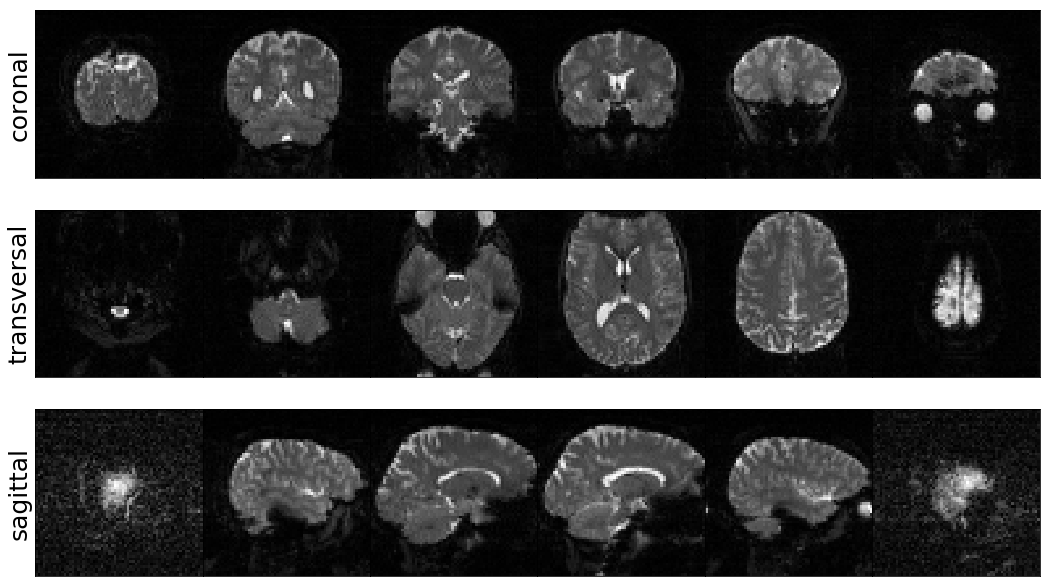

In [142]:
# Create a 3x6 subplot 
fig, ax = plt.subplots(3, 6, figsize=[18, 11])

# Orgaize the data for visualisation in the coronal plane
coronal = np.transpose(data_all, [1, 3, 2, 0])
coronal = np.rot90(coronal, 1)

# Orgaize the data for visualisation in the transversal plane
transversal = np.transpose(data_all, [2, 1, 3, 0])
transversal = np.rot90(transversal, 2)

# Orgaize the data for visualisation in the sagittal plane
sagittal = np.transpose(data_all, [2, 3, 1, 0])
sagittal = np.rot90(sagittal, 1)

# Plot some of the images in different planes
n = 10
for i in range(6):
    ax[0][i].imshow(coronal[:, :, n, 0], cmap='gray')
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    if i == 0:
        ax[0][i].set_ylabel('coronal', fontsize=25)
    n += 10
    
n = 5
for i in range(6):
    ax[1][i].imshow(transversal[:, :, n, 0], cmap='gray')
    ax[1][i].set_xticks([])
    ax[1][i].set_yticks([])
    if i == 0:
        ax[1][i].set_ylabel('transversal', fontsize=25)
    n += 10
    
n = 5
for i in range(6):
    ax[2][i].imshow(sagittal[:, :, n, 0], cmap='gray')
    ax[2][i].set_xticks([])
    ax[2][i].set_yticks([])
    if i == 0:
        ax[2][i].set_ylabel('sagittal', fontsize=25)
    n += 10

fig.subplots_adjust(wspace=0, hspace=0)
plt.show()

Looks good all three planes are displayed. You can play around with the parameters in the section above to visualize different slices. After all there are 64 slices in each plane and we only plotted 6 out of these 64 here.
Finally let’s have a look on the temporal domain. This is a bit trickier in terms of visualization since we will not get a nice image of the brain. Also, we don't know where something interesting might happen. So, the only thing we can do at the moment is to pick any voxel in any of the slices and plot its time course.

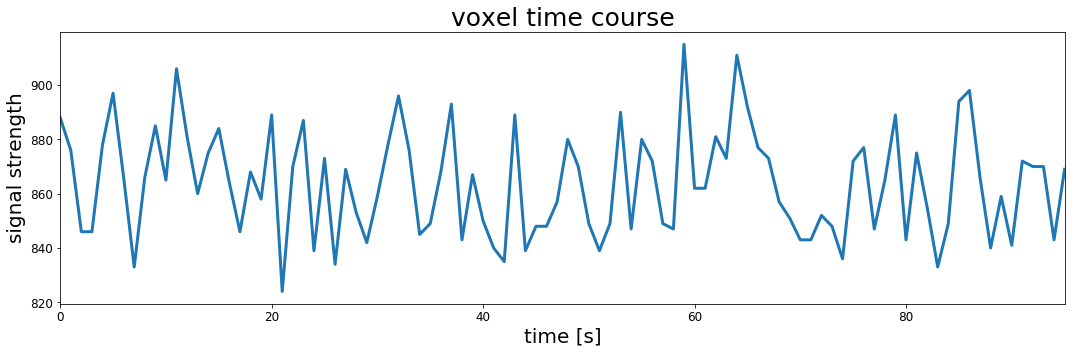

In [143]:
# Create an empty plot with defined aspect ratio
fig, ax = plt.subplots(1, 1, figsize=[18, 5])

# Plot the timecourse of a random voxel
ax.plot(transversal[30, 30, 35, :], lw=3)
ax.set_xlim([0, transversal.shape[3]-1])
ax.set_xlabel('time [s]', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
ax.set_title('voxel time course', fontsize=25)
ax.tick_params(labelsize=12)

plt.show()

Well it is a time course, right? It neither looks very meaningful nor does it seem to carry much information about what is going on in the brain. In order to get more insights out of this kind of data we actually need to put more effort into analyzing the temporal dimension of the data. Since this cannot be coded in two or three lines we will have a look at this in the next post/notebook. However, while we are at it we should save the data so that we can later just load it without having to do all the reorganization again.

The following code will create one .csv file for each slice that contains the spatial as well as the temporal dimensions. Because we only have two dimensions at hand in a .csv file we will reshape each slice into a MxN matrix where M = y_size $*$ x_size and N = n_volumes. When we read in the files again this procedure has to be reversed.

Before we finish I want to mention here that this is actually not the way you would store fMRI data these days (slice by slice as .csv files). However, I think for training purposes it is easier to get the general idea of how the data can be organized and rearranged. For a more up-to-date data format you can check out this link: https://nifti.nimh.nih.gov/

In [144]:
# Rearrange and reshape data for export
data_all = np.transpose(data_all, [3, 2, 1, 0])
data_all = np.reshape(data_all, [n_slice, y_size*x_size, n_volumes])

# Check if output path exists, if not create it.
if os.path.exists('./fMRI_data/csv_data') == False:
    os.mkdir('./fMRI_data/csv_data')

# Export each slice as a .csv file 
n = 0
for export in data_all:

    save_file = 'slice_{}.csv'.format(n)
    save_path = './fMRI_data/csv_data/{}'.format(save_file)
    pd.DataFrame(export).to_csv(save_path, header=False, index=False)
    n += 1